In [ ]:
!pip install cmdstanpy==0.9.68
!pip install pystan==2.19.1.1
!pip install prophet

In [39]:
from prophet import Prophet
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet.plot import add_changepoints_to_plot
from scipy import stats
%config InlineBackend.figure_format = 'svg'

In [3]:
data = pd.read_excel('BST_DataSet.xlsx')
data = data.rename(columns={'Unnamed: 0': 'ds', 'Прирост вкладов физических лиц в рублях (млн руб)': 'y'})
data

,ds,y,Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, руб","М2, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
0,2011-01-01,-79049.0,5.244667,7.75,2.90,4.50,96.29,106.171510,5.532900e+06,19307.700000,30.08,20669
1,2011-02-01,180475.0,5.144211,8.00,3.10,4.40,103.96,106.999640,5.613700e+06,19536.700000,29.29,20680
2,2011-03-01,106845.0,5.021364,8.00,3.10,4.20,114.44,107.663040,5.647000e+06,19788.700000,28.43,22673
3,2011-04-01,224890.0,4.558571,8.00,2.60,4.10,123.15,108.125990,5.863400e+06,20020.800000,28.10,22519
4,2011-05-01,45856.0,4.795000,8.25,2.60,4.10,114.46,108.645000,5.893400e+06,20160.900000,27.87,22779
...,...,...,...,...,...,...,...,...,...,...,...,...
79,2017-08-01,NaN,7.882174,9.00,0.73,6.07,52.00,168.418880,9.194600e+06,39419.300000,59.65,37099
80,2017-09-01,NaN,7.648095,8.50,0.66,5.31,57.00,168.166250,9.225200e+06,39571.000000,57.73,38047
81,2017-10-01,NaN,7.503636,8.25,0.61,5.67,57.50,168.502590,9.246600e+06,39565.982237,57.71,38333
82,2017-11-01,NaN,7.381429,8.25,0.64,5.18,63.10,168.852459,9.281212e+06,40101.582544,58.92,38848


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


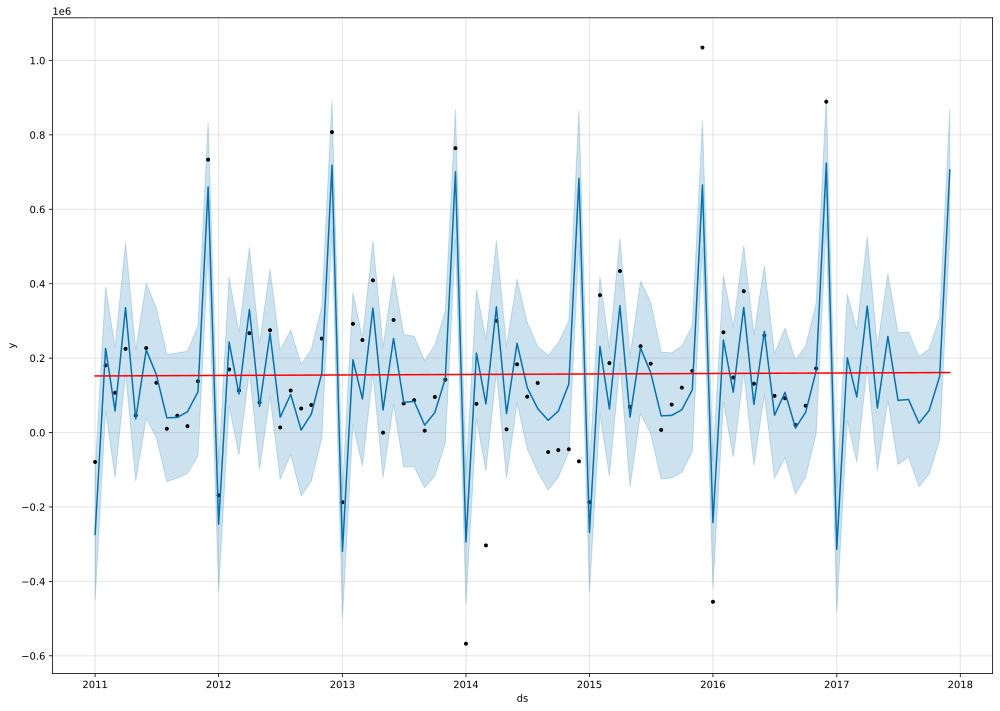

In [4]:
m = Prophet(changepoint_prior_scale=0.05)
forecast = m.fit(data).predict(data)
fig = m.plot(forecast, figsize=(14,10))
a = add_changepoints_to_plot(fig.gca(), m, forecast)

Заметного восходящего или низходящего тренда практически нет, но заметна сезонность. Есть небольшие выбросы. Видим, что к концу года есть резкий скачок вверх и потом вниз, а дальше по основному тренду движение продолжается. Возможно, это связано с годовой отчётностью или другими сезонными факторами.

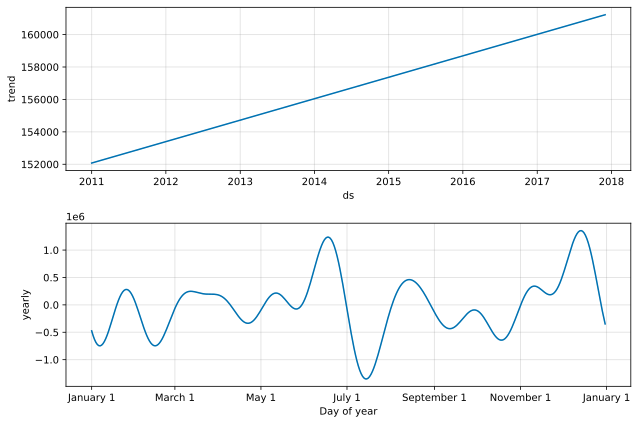

In [5]:
fig = m.plot_components(forecast)

Тут лучше видно. Теперь виден восходящий тренд. Кроме того, теперь лучше видна сезонность. Можно видеть, что прирост вкладов физ лиц резко возрастает в июне и падает в июле, а потом возвращается к среднему за год в августе. Примерно это же повторяется в декабре-январе.

Попробуем выяснить причину по имеющимся данным.

In [6]:
data.y.mean()/10**6

0.1466405

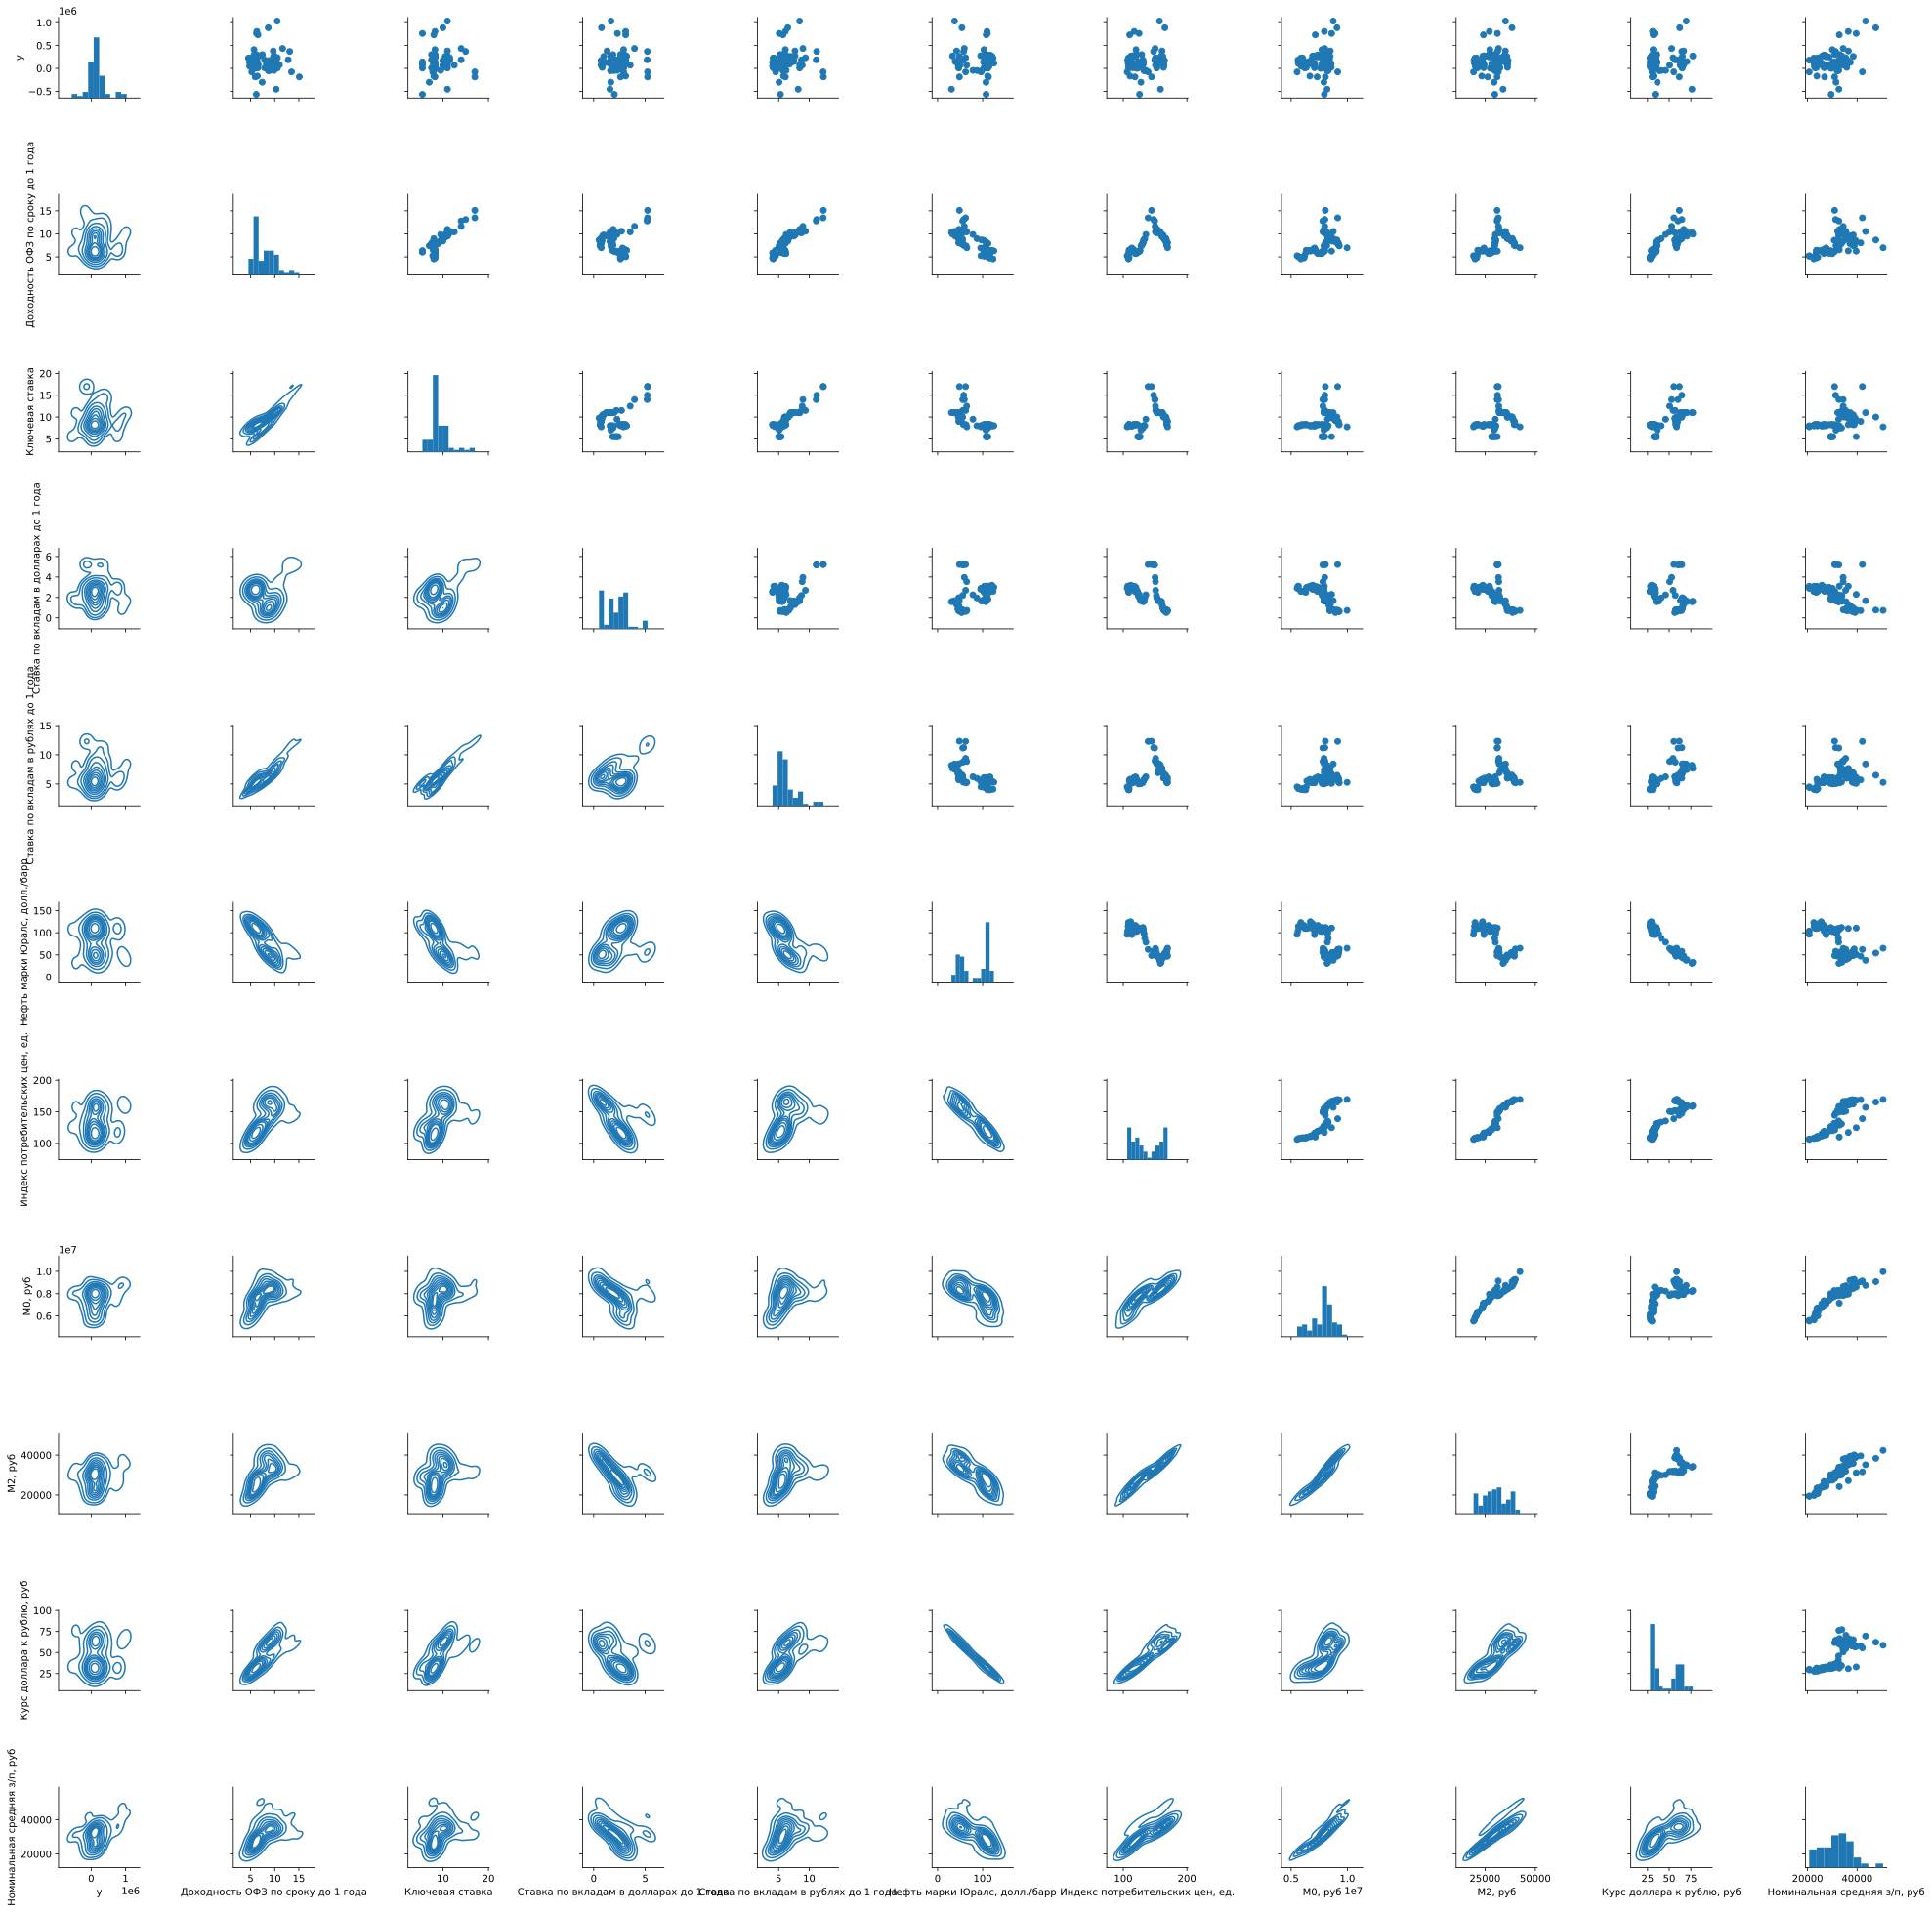

In [7]:
g = sns.PairGrid(data.drop(columns='ds'))
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot);

На первый взгляд особой корреляций с таргетом нет.

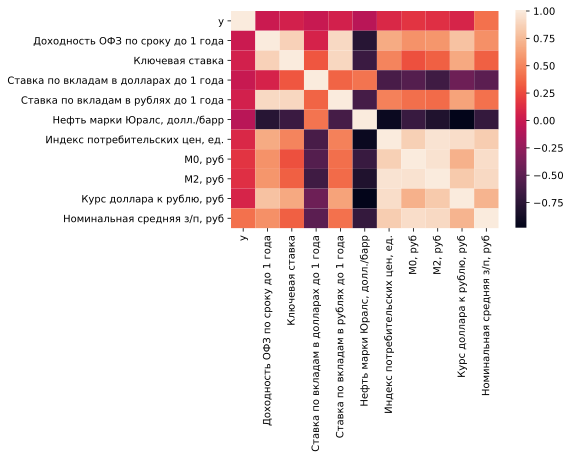

In [8]:
sns.heatmap(data.drop(columns='ds').corr())

Теперь корреляцию лучше видно.  (Пирсон)

Весьма логичено, что индекс потребительских цен коррелирует с количеством денег у потребителей и номинальной средней з/п. Кроме того, как можем заметить, они так же коррелируют с курсом доллара. Из интересного то, что курс доллара отрицательно коррелирует с ценой за баррель нефти, а цена за баррель отрицательно коррелирует с индексом потребительских цен. 
Ещё видна хорошая корреляцияключевой ставки и доходностью ОФЗ, что весьма логично. Из неочевидного для меня осталось - отрицательная корреляция цены за баррель нефти и индексом потребительских цен. Хотя это тоже можно объяснить корреляцией цены рубля и цены Юралса. Чем дороже Юралс, тем дороже рубль. Чем дороже рубль, тем ниже цены на товары, и тем ниже индекс потребительских цен.

Посмотрим вообще на данные получше

Сначала посмотрим на распределения и сделаем тест на нормальность

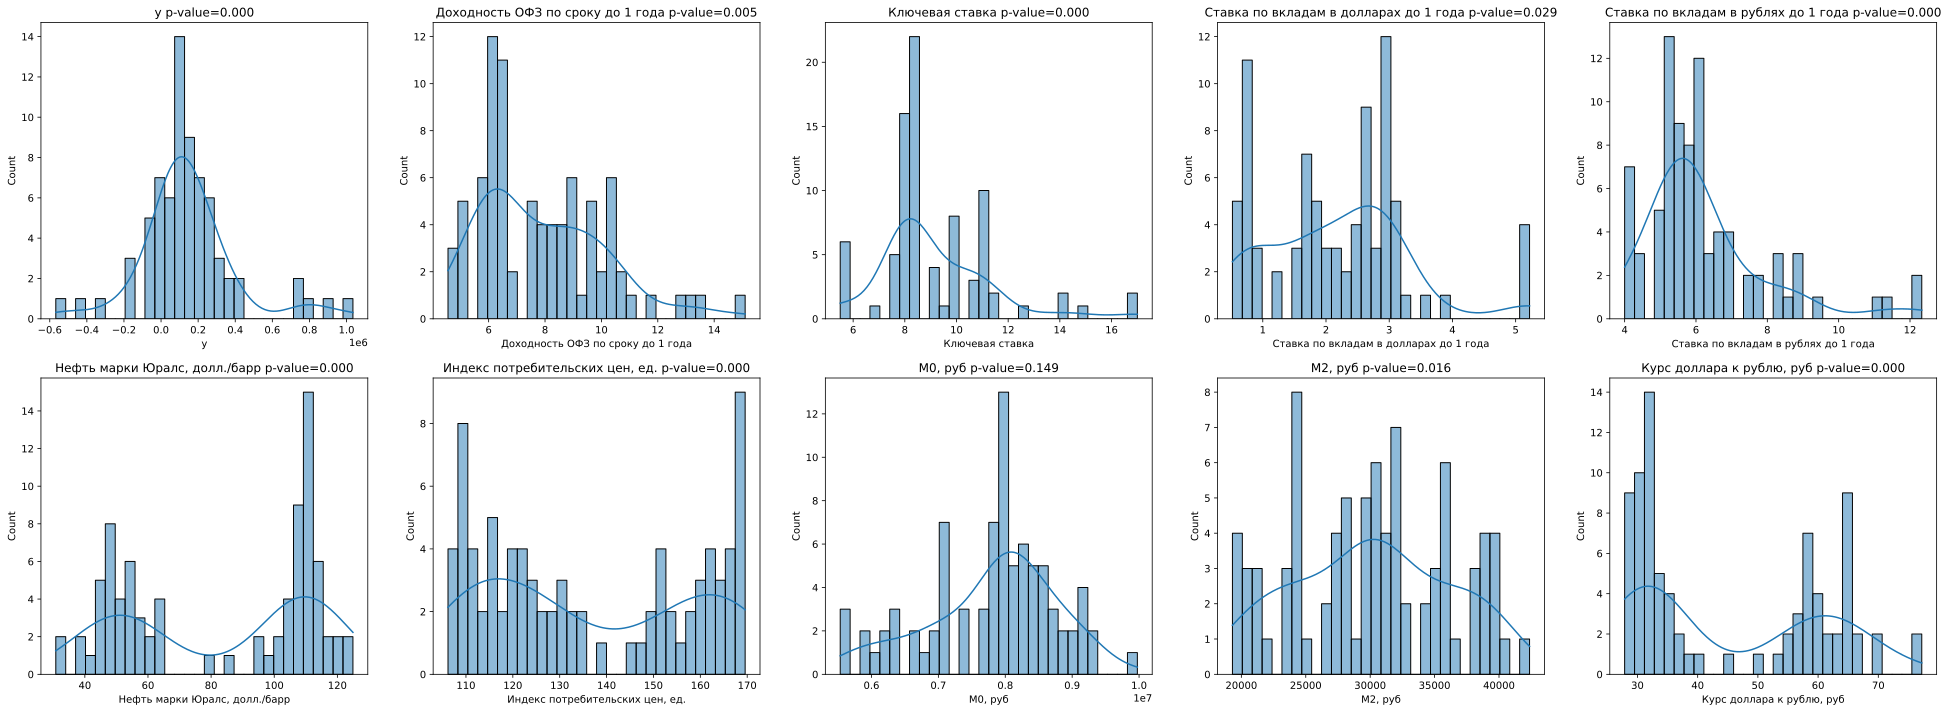

In [9]:
fig, ax = plt.subplots(2,5, figsize=(34,12))
labels = data.columns
h=0
for i in range(2):
  for j in range(5):
    h+=1
    sns.histplot(data=data, x=labels[h], bins=30, kde=True, ax=ax[i][j])
    _, p = stats.normaltest(data[labels[h]].dropna())
    ax[i][j].set_title(labels[h]+' p-value=%.3f' % p)

Кажется, что цена на нефть имеет бимодальное распределение. Возможно, около каждой моды нормальное распределение. Кроме того, видим, что объём наличных средств M0 имеет нормальное распределение.

In [19]:
X_pred = data[data.y.isin([None])].drop(columns=['ds', 'y'])
X = data[data.y.isin([None]) == False].drop(columns=['ds', 'y'])
y = data[data.y.isin([None]) == False].y
X.shape, y.shape, X_pred.shape

((72, 10), (72,), (12, 10))

In [43]:
pca = PCA(n_components=1).fit(X)

X_pca = pca.transform(X)

In [44]:
X_pca.reshape(-1).shape, y.shape

((72,), (72,))

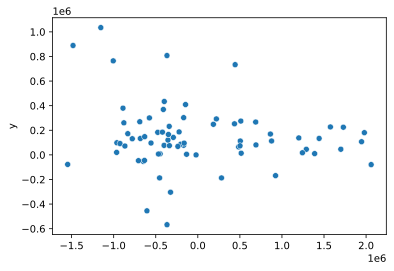

In [45]:
sns.scatterplot(x=X_pca.reshape(-1), y=y)

In [46]:
reg = LinearRegression().fit(X_pca, y)
reg.score(X_pca, y)

0.025909791321794606

In [51]:
z_X = StandardScaler().fit_transform(X)
z_y = StandardScaler().fit_transform(y.values.reshape(-1,1)).reshape(-1)
z_X.shape, y.shape

((72, 10), (72,))

In [68]:
pca = PCA(n_components=1).fit(z_X)

X_pca = pca.transform(z_X)

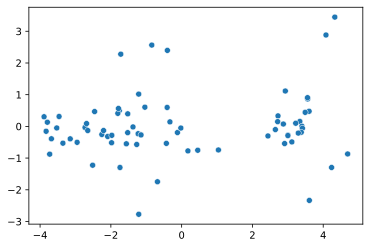

In [69]:
sns.scatterplot(x=X_pca.reshape(-1), y=z_y)

In [70]:
reg = LinearRegression().fit(X_pca, z_y)
reg.score(X_pca, z_y)

0.017387534398128457

In [57]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.561958699302129

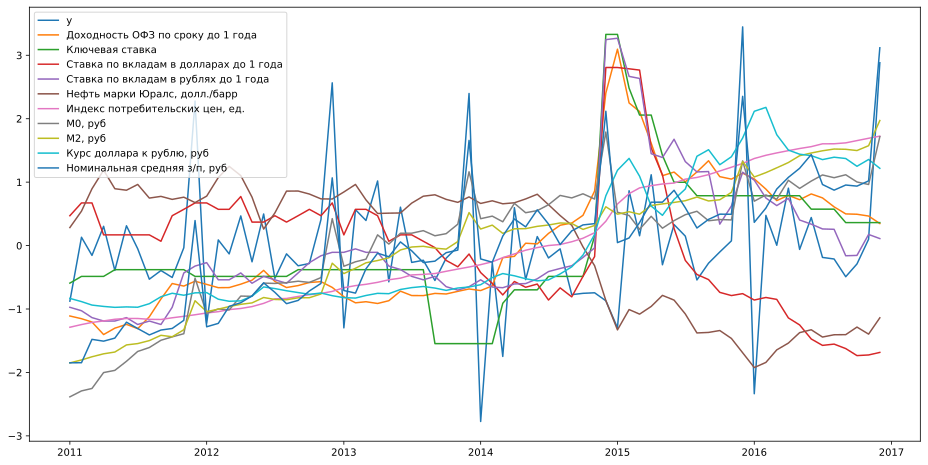

In [91]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=data.ds.values[:72], y=z_y, label=data.columns[1])
for i, x in enumerate(z_X.T):
  sns.lineplot(x=data.ds.values[:72], y=x, label=data.columns[i+2])

1. Есть явная корреляция номинальной средней з/п и таргетом. Это логично, ведь чем больше з/п, тем больше свободных средств, если при этом не увеличивается инфляция. А это можно проверить курсом доллара. Как видим, рубль дешевел к доллару, номинальная з/п росла. Можно ли тогда утверждать, что с ростом инфляции люди имели больше свободных средств, чтобы делать вклады? Возможно, если тем самым они пытались опередить инфляцию или уменьшить потери. 

2. Теперь посмотрим на объём денежных средств M0 и M2. Видим явный тренд. Конечно это коррелирует с индексом потребительских цен, ведь с ростом денежных средств у людей растёт и инфляция (конечно не всегда), а с этим растут и цены на товары, двигая индекс вверх.


In [93]:
dt = pd.DataFrame(z_X, columns=data.columns[2:])
dt['y'] = z_y
dt

,Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, руб","М2, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб",y
0,-1.109781,-0.591671,0.470896,-0.972968,0.284148,-1.287248,-2.384444,-1.848730,-0.832565,-1.848422,-0.876198
1,-1.152654,-0.485700,0.672289,-1.027138,0.542607,-1.245136,-2.290929,-1.802952,-0.883033,-1.846390,0.131356
2,-1.205083,-0.485700,0.672289,-1.135480,0.895755,-1.211400,-2.252388,-1.752576,-0.937973,-1.478222,-0.154499
3,-1.402595,-0.485700,0.168806,-1.189651,1.189259,-1.187858,-2.001935,-1.706179,-0.959054,-1.506670,0.303789
4,-1.301691,-0.379729,0.168806,-1.189651,0.896429,-1.161464,-1.967214,-1.678172,-0.973747,-1.458640,-0.391277
...,...,...,...,...,...,...,...,...,...,...,...
67,0.610020,0.574009,-1.553103,0.256709,-1.405774,1.605127,1.069939,1.522019,1.393122,0.873768,-0.211480
68,0.499335,0.362067,-1.623590,-0.160406,-1.404089,1.619222,1.116465,1.517861,1.372679,0.954680,-0.490603
69,0.493949,0.362067,-1.734356,-0.154989,-1.284801,1.654937,1.002696,1.498310,1.250024,0.937315,-0.289634
70,0.465700,0.362067,-1.724287,0.175453,-1.395665,1.691638,0.962999,1.574673,1.357347,1.019705,0.099708


In [111]:
dt.corr().y[:-1]

Доходность ОФЗ по сроку до 1 года         0.001829
Ключевая ставка                           0.048946
Ставка по вкладам в долларах до 1 года   -0.012823
Ставка по вкладам в рублях до 1 года      0.053989
Нефть марки Юралс, долл./барр            -0.077074
Индекс потребительских цен, ед.           0.098694
М0, руб                                   0.160956
М2, руб                                   0.135086
Курс доллара к рублю, руб                 0.077381
Номинальная средняя з/п, руб              0.405291
Name: y, dtype: float64

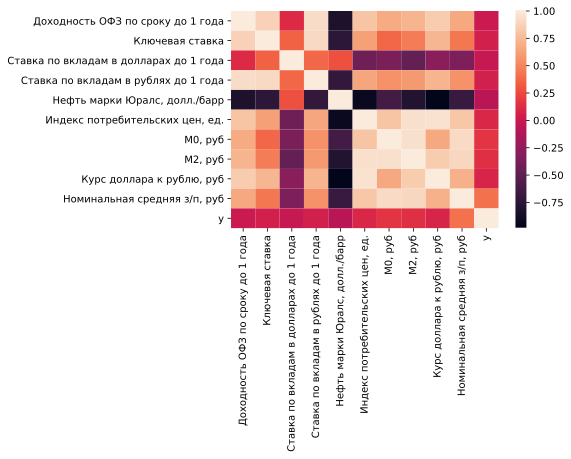

In [94]:
sns.heatmap(dt.corr())

Вывод:

   Прирост вкладов физических лиц явно зависит от уровня инфляции. Если мы измеряем прирост вкладов физ лиц в рублях, то нужно смотреть на уровень инфляции в России. Можно обойтись без этого, ведь Росстат не даёт правдивой оценки уровня инфляции, поэтому можно понаблюдать за индексом потребительских цен, курсу доллара, юаня, евро, золота и т.д. 
   
   Из этих данных можно выделить явный восходящий тренд прироста вкладов физ лиц, как я думаю, благодаря росту инфляции в стране и не столь быстрому ухудшению уровня жизни.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


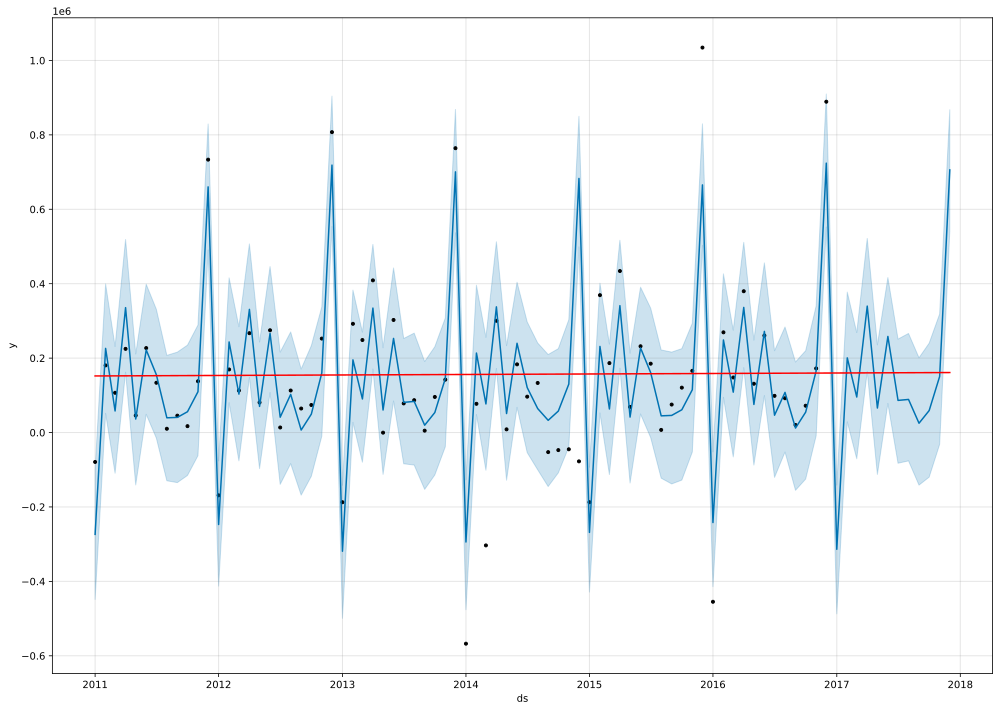

In [112]:
m = Prophet(changepoint_prior_scale=0.05)
forecast = m.fit(data).predict(data)
fig = m.plot(forecast, figsize=(14,10))
a = add_changepoints_to_plot(fig.gca(), m, forecast)

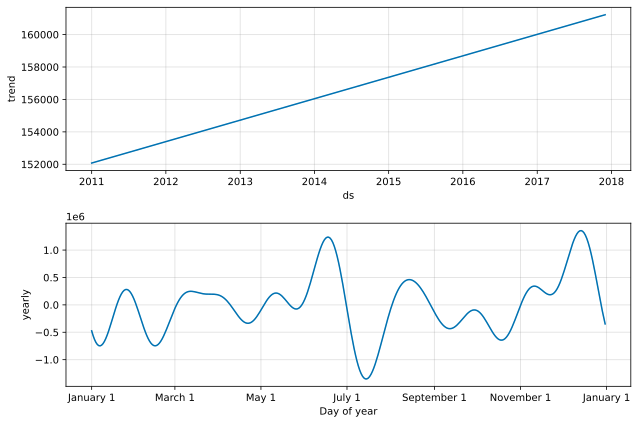

In [113]:
fig = m.plot_components(forecast)